# Introduction
San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz. Today, the city is known more for its tech scene than its criminal past. 
From Sunset to SOMA, and Marina to Excelsior, this project analyzes 12 years of crime reports from across all of San Francisco's neighborhoods to create a model that predicts the category of crime that occurred, given time and location.  
# Definition  
## Project Overview  
Crime is a social phenomenon as old as societies themselves, and although there will never be a free from crime society - just because it would need everyone in that society to think and act in the same way - societies always look for a way to minimize it and prevent it.
In the modern United States history, crime rates increased after World War II, peaking from the 1970s to the early 1990s. Violent crime nearly quadrupled between 1960 and its peak in 1991. Property crime more than doubled over the same period. Since the 1990s, however, crime in the United States has declined steadily.
Until recently crime prevention was studied based on strict behavioral and social methods, but the recent developments in Data Analysis have allowed a more quantitative approach in the subject. We will explore a dataset of nearly 12 years of crime reports from across all of San Francisco's neighborhoods, and we will create a model that predicts the category of crime that occurred, given the time and location.  
## Problem Statement
To examine the specific problem, we will apply a full Data Science life cycle composed of the following steps:
1. Data Wrangling to audit the quality of the data and perform all the necessary actions to clean the dataset.
2. Data Exploration for understanding the variables and create intuition on the data.
3. Feature Engineering to create additional variables from the existing.
4. Data Normalization and Data Transformation for preparing the dataset for the learning algorithms (if needed).
5. Training / Testing data creation to evaluate the performance of our models and fine-tune their hyperparameters.
6. Model selection and evaluation. This will be the final goal; creating a model that predicts the probability of each type of crime based on the location and the date.  

## Metrics
The most appropriate evaluation metric for such problems is the **multi-class logarithmic loss**. Logarithmic loss measures the performance of a classification model where the prediction output is a probability value between 0 and 1. For each incident, we will predict a set of predicted probabilities (one for every class), and we will calculate the average deviation from the real values. 
To get a little more intuition on the metric, for a specific incident:
* We get 0 loss from the categories of crimes that did not happen (since yij =0 yijlog(pij)) no matter our predicted probability.
* We get log(pij) loss from the category that happened, where pij is our predicted probability for the specific category.  

We have to note here that since all the probabilities for a specific incident sum to 1, each probability we predict for a category that did not happen creates an “indirect” loss since it decreases our predicted probability for the category of crime that happened.
In other words, the metric evaluates the certainty of our model for each category of crime/incident.  

# Analysis  
## Data Exploration  
The dataset is in a tabular form and includes chronological, geographical and text data and contains incidents derived from the SFPD Crime Incident Reporting system. 

In [29]:
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from matplotlib import cm
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx
import geoplot as gplt
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from pdpbox import pdp, info_plots
import shap

In [30]:
train = pd.read_csv('train.csv', parse_dates=['Dates'])
test = pd.read_csv('test.csv', parse_dates=['Dates'], index_col='Id')

In [31]:
print('First date: ', str(train.Dates.describe()['first']))
print('Last date: ', str(train.Dates.describe()['last']))
print('Test data shape ', train.shape)

KeyError: 'first'

The data ranges from 1/1/2003 to 5/13/2015 creating a training dataset with nine features and 878,049 samples

In [ ]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


More specifically it includes the following variables.
* Dates - timestamp of the crime incident
* Category - category of the crime incident. (This is our target variable.)
* Descript - detailed description of the crime incident
* DayOfWeek - the day of the week
* PdDistrict - the name of the Police Department District
* Resolution - The resolution of the crime incident
* Address - the approximate street address of the crime incident 
* X - Longitude
* Y - Latitude


In [ ]:
train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

The dataset contains a lot of 'object' variables (aka strings) that we will need to encode.

In [ ]:
train.duplicated().sum()

np.int64(2323)

It also contains 2323 duplicates that we should remove.  
We will also evaluate the position of the data points using the coordinates.

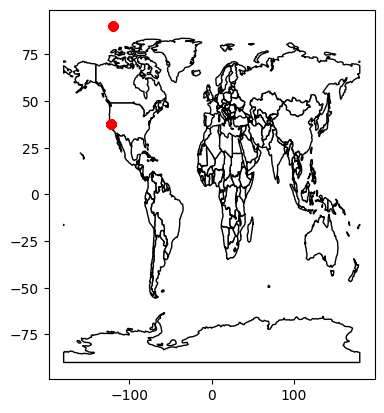

In [ ]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

Some points are misplaced. Let's see how many they are.

In [ ]:
print(train_gdf.loc[train_gdf.Y > 50].count()[0])
train_gdf.loc[train_gdf.Y > 50].sample(5)

67


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Coordinates
839585,2003-07-08 19:22:00,WARRANTS,ENROUTE TO DEPARTMENT OF CORRECTIONS,Tuesday,SOUTHERN,"ARREST, BOOKED",1ST ST / BRANNAN ST,-120.5,90.0,POINT (-120.5 90)
857248,2003-04-14 16:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,BAYVIEW,COMPLAINANT REFUSES TO PROSECUTE,GILMAN AV / FITCH ST,-120.5,90.0,POINT (-120.5 90)
673114,2005-10-23 18:11:00,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Sunday,TARAVAL,"ARREST, BOOKED",STCHARLES AV / 19TH AV,-120.5,90.0,POINT (-120.5 90)
842435,2003-06-24 18:35:00,WARRANTS,WARRANT ARREST,Tuesday,NORTHERN,"ARREST, BOOKED",AUSTIN ST / LARKIN ST,-120.5,90.0,POINT (-120.5 90)
674043,2005-10-21 10:15:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.5,90.0,POINT (-120.5 90)


We will replace the outlying coordinates with the average coordinates of the district they belong.

In [ ]:
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.nan, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.nan, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])

train_gdf = create_gdf(train)

After cleaning the dataset from outliers and duplicates, we examine the variables.  
### Dates & Day of the week  
These variables are distributed uniformly between 1/1/2003 to 5/13/2015 (and Monday to Sunday) and split between the training and the testing dataset as mentioned before. We did not notice any anomalies on these variables.  
The median frequency of incidents is 389 per day with a standard deviation of 48.51.

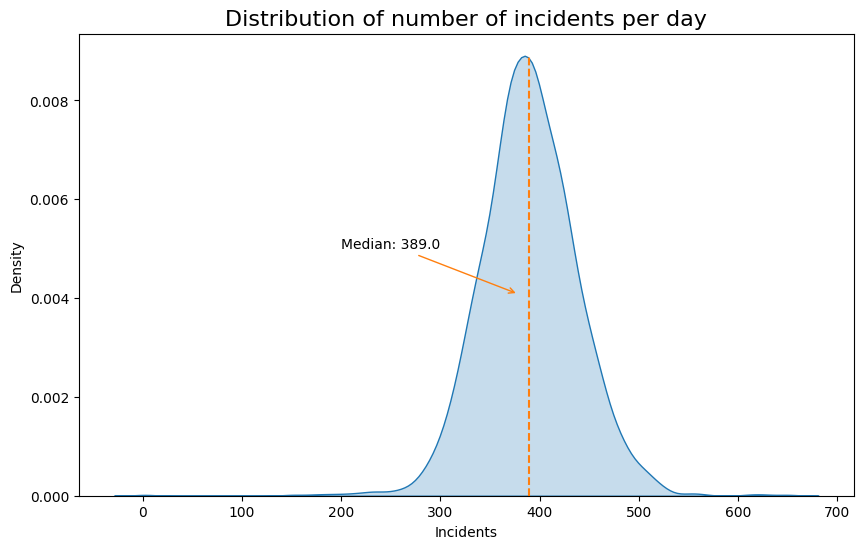

In [ ]:
col = sns.color_palette()

train['Date'] = train.Dates.dt.date
train['Hour'] = train.Dates.dt.hour

plt.figure(figsize=(10, 6))
data = train.groupby('Date').count().iloc[:, 0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[1])
plt.annotate(
    'Median: ' + str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
plt.title(
    'Distribution of number of incidents per day', fontdict={'fontsize': 16})
plt.xlabel('Incidents')
plt.ylabel('Density')
plt.legend().remove()
plt.show()

Also, there is no significant deviation of incidents frequency throughout the week. Thus we do not expect this variable to play a significant role in the prediction.

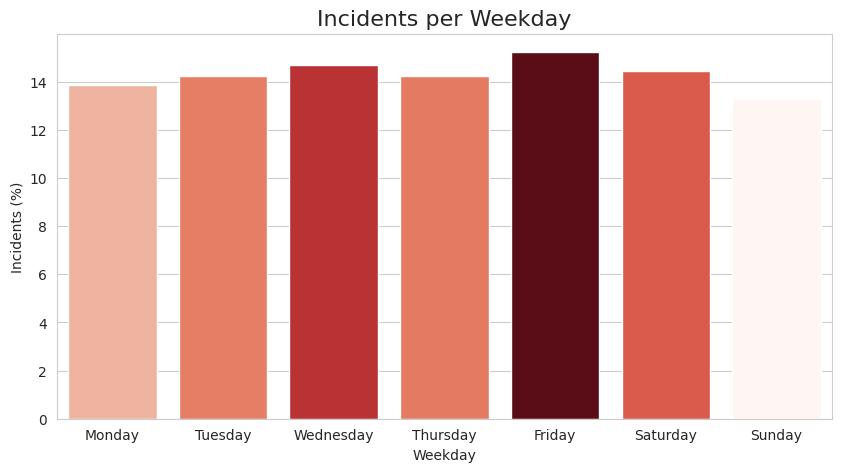

In [ ]:
data = train.groupby('DayOfWeek').count().iloc[:, 0]
data = data.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])

plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x=data.index,
        y=(data.values / data.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Reds').to_rgba(data.values))

plt.title('Incidents per Weekday', fontdict={'fontsize': 16})
plt.xlabel('Weekday')
plt.ylabel('Incidents (%)')

plt.show()

### Category  
There are 39 discrete categories that the police department file the incidents with the most common being Larceny/Theft (19.91%), Non/Criminal (10.50%), and Assault(8.77%).

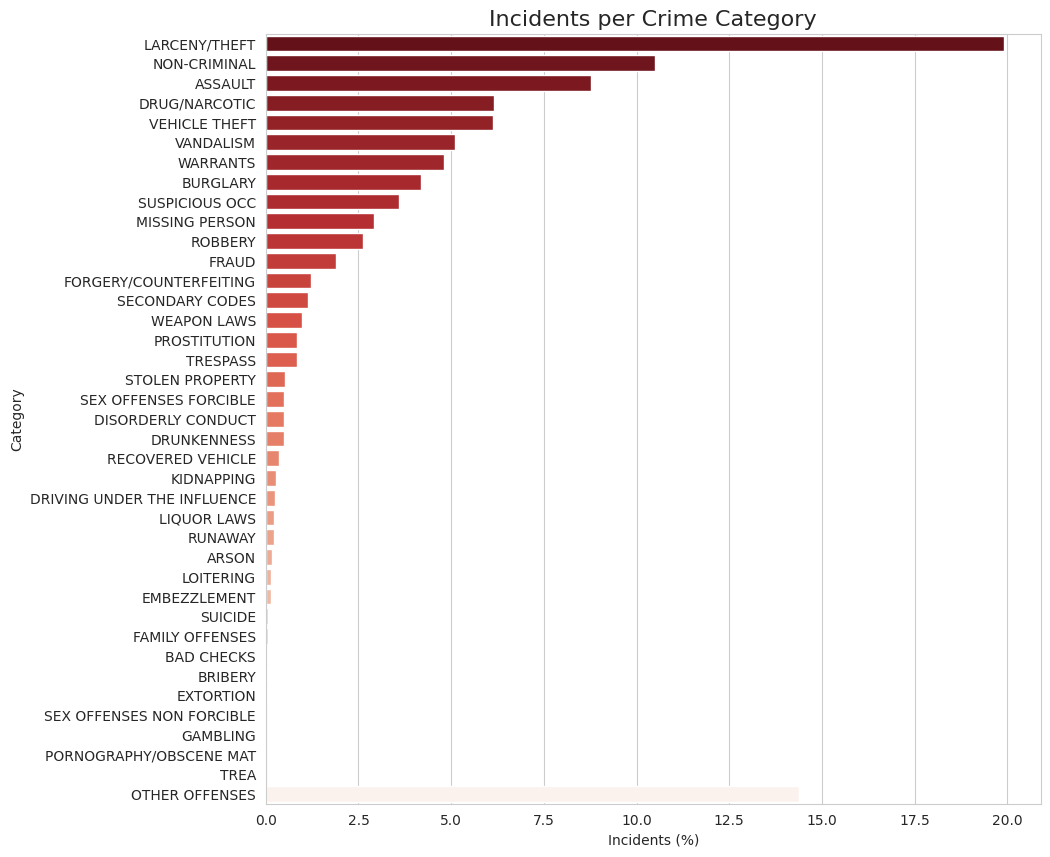

In [ ]:
data = train.groupby('Category').count().iloc[:, 0].sort_values(
    ascending=False)
data = data.reindex(np.append(np.delete(data.index, 1), 'OTHER OFFENSES'))

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x=(data.values / data.values.sum()) * 100,
        y=data.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')
plt.show()

### Police District  
There are significant differences between the different districts of the City with the Southern district having the most incidents (17.87%) followed by Mission (13.67%) and Northern (12.00%).

In [ ]:
# Downloading the shapefile of the area 
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
# Defining the coordinate system to longitude/latitude
pd_districts.crs={'init': 'epsg:4326'}

# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    train.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_on='district',
    right_index=True,
    suffixes=('_x', '_y'))

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
train_days = train.groupby('Date').count().shape[0]
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()

HTTPError: HTTP Error 500: Server Error

### Address  
Address, as a text field, requires advanced techniques to use it for the prediction. Instead in this project, we will use it to extract if the incident has happened on the road or in a building block.  
### X - Longitude Y - Latitude  
We have tested that the coordinates belong inside the boundaries of the city. Although longitude does not contain any outliers, latitude includes some 90o values which correspond to the North Pole. 
## Exploratory Visualization
Based on the Project’s statement, we need to predict the probability of each type of crime based on time and location. That being said, we present two diagrams to visualize the importance of these variables.
The first one presents the geographic density of 9 random crime categories. We can see that although the epicenter of most of the crimes resides on the northeast of the city, each crime has a different density on the rest of the city. This fact is a reliable indication that the location ( coordinates / Police District) will be a significant factor for the analysis and the forecasting. 


In [ ]:
crimes = train['Category'].unique().tolist()
crimes.remove('TREA')

pd_districts = pd_districts.to_crs({'init':'epsg:4326'})
sf_land = pd_districts.unary_union
sf_land = gpd.GeoDataFrame(gpd.GeoSeries(sf_land), crs={'init':'epsg:4326'})
sf_land = sf_land.rename(columns={0:'geometry'}).set_geometry('geometry')

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))
for i , crime in enumerate(np.random.choice(crimes, size=9, replace=False)):
    data = train_gdf.loc[train_gdf['Category'] == crime]
    ax = fig.add_subplot(3, 3, i+1)
    gplt.kdeplot(data,
                 shade=True,
                 shade_lowest=False,
                 clip = sf_land.geometry,
                 cmap='Reds',
                 ax=ax)
    gplt.polyplot(sf_land, ax=ax)
    ax.set_title(crime) 
plt.suptitle('Geographic Density of Different Crimes')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The second diagram presents the average number of incidents per hour for five of the crimes' categories. It is evident that different crimes have different frequency during different times of the day. 
Some examples are that prostitution picks during the evening and all through the night, Gambling incidents start late at night until the morning and Burglary picks early in the morning until the afternoon.
As before these are sharp pieces of evidence that the time parameters will have a significant role also.


In [ ]:
data = train.groupby(['Hour', 'Date', 'Category'],
                     as_index=False).count().iloc[:, :4]
data.rename(columns={'Dates': 'Incidents'}, inplace=True)
data = data.groupby(['Hour', 'Category'], as_index=False).mean()
data = data.loc[data['Category'].isin(
    ['ROBBERY', 'GAMBLING', 'BURGLARY', 'ARSON', 'PROSTITUTION'])]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 4))
ax = sns.lineplot(x='Hour', y='Incidents', data=data, hue='Category')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.suptitle('Average number of incidents per hour')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Algorithms and Techniques  
The specific problem is a typical multiclass classification problem, and there are several categories of algorithms for solving it. Initially, we evaluated several appropriate algorithms from Linear Models (Stochastic Gradient Descent), Nearest Neighbors (K nearest neighbors), Ensemble methods (Random Forests & AdaBoost) and Boosting Algorithms (XGBoost & LIghtGBM) using basic feature engineering and the default parameters to evaluate if any of them has a significant head start:  

| **Algorithm**                   | **Parameters**                                        | **Logloss**  |
|:---------------------------:|:-------------------------------------------------:|:--------:|
| Stochastic Gradient Descent | Default Scikit-Learn Parameters (with 'log' loss) |  2.86631 |
| K-Nearest Neighbors         | Default Scikit-Learn Parameters                   | 23.29263 |
| Random Forest               | Default Scikit-Learn Parameters                   |  2.92716 |
| AdaBoost                    | Default Scikit-Learn Parameters                   |  3.58856 |
| XGBoost                     | Default Scikit-Learn Parameters                   |  2.91656 |
| LIghtGBM                    | Default Scikit-Learn Parameters                   |  2.98336 |  

SGD scored the best initial result, but after a lengthy hyperparameter tuning, it was not able to pass a 2.54503 threshold.  

Finally, from the algorithms that scored under 3.0, we decided to work with LightGBM due to its efficiency and versatility in the hyperparameters tuning.
LightGBM is a decision tree boosting algorithm uses histogram-based algorithms which bucket continuous feature (attribute) values into discrete bins. This technique speeds up training and reduces memory usage. In layman terms the algorithm works like this:  

1. Fit a decision tree to the data
2. Evaluate the model
3. Increase the weight to the incorrect samples.
4. Choose the leaf with max delta loss to grow.
5. Grow the tree.
6. Go to step 2 ![lightgbm](https://lightgbm.readthedocs.io/en/latest/_images/leaf-wise.png) 

## Benchmark  
There are two types of benchmarks we need to set. The first will be a naive prediction. This prediction will be a baseline score to compare with our model’s score to evaluate if we have any significant progress.  

In a Multiclass Classification, the best way to calculate the baseline is by assuming that the probability of each category equals its average frequency in the train set. The frequency can be calculated easily by dividing the sum of incidents of each category by the number of rows of the training set.


In [ ]:
naive_vals = train.groupby('Category').count().iloc[:,0]/train.shape[0]
n_rows = test.shape[0]

submission = pd.DataFrame(
    np.repeat(np.array(naive_vals), n_rows).reshape(39, n_rows).transpose(),
    columns=naive_vals.index)

The baseline calculated this way is 2.68015. (Details in [SF-Crime Analysis & Prediction (Naive Prediction)](https://www.kaggle.com/yannisp/sf-crime-analysis-prediction-naive-prediction) Notebook. We can notice that this baseline is already lower than the initial score of our classifiers.  

Another critical benchmark is usually the ‘Human Performance’, as a proxy for the Bayes error rate. The specific problem does not belong to a field that humans excel (like computer vision or NLP), so as a proxy for the  [Bayes error rate](https://en.wikipedia.org/wiki/Bayes_error_rate), we will use the score of the best kernel so far which is [initial benchmark need tuning](https://www.kaggle.com/sergeylebedev/initial-benchmark-need-tuning) by the user [Sergey Lebedev](https://www.kaggle.com/sergeylebedev) with score 2.29318. 

The small distance between the baseline score and the Bayes error rate indicate that this is a hard problem with a low margin of improvement.  
# Methodology
## Data Preprocessing
### Data Wrangling
Following the methodology described in the Problem Statement, we identified 2323 duplicate values and 67 wrong latitudes. The duplicates removed and the outliers imputed.  
### Feature Engineering
Then, we created additional features. More specifically:
* From the ‘Dates’ field, we extracted the Day, the Month, the Year, the Hour, the Minute, the Weekday, and the number of days since the first day in the data.
* From the ‘Address’ field we extracted if the incident has taken place in a crossroad or on a building block.




In [ ]:
def feature_engineering(data):
    data['Date'] = pd.to_datetime(data['Dates'].dt.date)
    data['n_days'] = (
        data['Date'] - data['Date'].min()).apply(lambda x: x.days)
    data['Day'] = data['Dates'].dt.day
    data['DayOfWeek'] = data['Dates'].dt.weekday
    data['Month'] = data['Dates'].dt.month
    data['Year'] = data['Dates'].dt.year
    data['Hour'] = data['Dates'].dt.hour
    data['Minute'] = data['Dates'].dt.minute
    data['Block'] = data['Address'].str.contains('block', case=False)
    
    data.drop(columns=['Dates','Date','Address'], inplace=True)
        
    return data

In [26]:
train = feature_engineering(train)
train.drop(columns=['Descript','Resolution'], inplace=True)
test = feature_engineering(test)
train.head()

,Category,DayOfWeek,PdDistrict,X,Y,Hour,n_days,Day,Month,Year,Minute,Block
0,WARRANTS,2,NORTHERN,-122.425892,37.774599,23,4510,13,5,2015,53,False
1,OTHER OFFENSES,2,NORTHERN,-122.425892,37.774599,23,4510,13,5,2015,53,False
2,OTHER OFFENSES,2,NORTHERN,-122.424363,37.800414,23,4510,13,5,2015,33,False
3,LARCENY/THEFT,2,NORTHERN,-122.426995,37.800873,23,4510,13,5,2015,30,True
4,LARCENY/THEFT,2,PARK,-122.438738,37.771541,23,4510,13,5,2015,30,True


### Feature Scaling
Deciding to continue with a tree-based algorithm there was no need for scaling on the final dataset.
### Feature Selection
After the feature engineering described above, we ended up with 11 features. To identify if any of them increased the complexity of the model without adding significant gain to the model, we used the method of Permutation Importance.  

The idea is that the importance of a feature can be measured by looking at how much the loss decreases when a feature is not available. To do that we can remove each feature from the dataset, re-train the estimator and check the impact. Doing this would require re-training an estimator for each feature, which can be computationally intensive. Instead, we can replace it with noise by shuffle values for a feature.  

The implementation of the above technique showed that there is no need for any feature removal since all of them have a positive impact in the dataset.


In [27]:
le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])
le2 = LabelEncoder()
y = le2.fit_transform(train.pop('Category'))

train_X, val_X, train_y, val_y = train_test_split(train, y)

model = LGBMClassifier(objective='multiclass', num_class=39).fit(train_X, train_y)

val_preds = model.predict(val_X)
val_accuracy = accuracy_score(val_y, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

perm = PermutationImportance(model).fit(val_X, val_y)
eli5.show_weights(perm, feature_names=val_X.columns.tolist())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 656794, number of used features: 11
[LightGBM] [Info] Start training from score -6.376724
[LightGBM] [Info] Start training from score -2.437100
[LightGBM] [Info] Start training from score -7.698032
[LightGBM] [Info] Start training from score -8.024488
[LightGBM] [Info] Start training from score -3.169482
[LightGBM] [Info] Start training from score -5.321411
[LightGBM] [Info] Start training from score -5.965605
[LightGBM] [Info] Start training from score -2.788219
[LightGBM] [Info] Start training from score -5.320165
[LightGBM] [Info] Start training from score -6.625484
[LightGBM] [Info] Start training from score -8.180190
[LightGBM] [Info] Start training from score -7.468200

KeyboardInterrupt: 

## Building the Initial Model
To build the model we used the LightGBM’s Python API.
First we created the dataset by combining the features, the target and declaring the PdDistrict as a categorical variable using ‘lightgbm.Dataset()`.  

Then we used Cross-Validation with early stopping (10 rounds) and parameters:  
* Objective = ‘'multiclass',  
* 'Metric = ‘multi_logloss',  
* 'Num_class = 39  

The above setup achieved 2.46799  cross-validation score after 23 epochs and 2.49136 on the testing set.  
[SF-Crime Analysis & Prediction (Base Model)](https://www.kaggle.com/yannisp/sf-crime-analysis-prediction-base-model/notebook?scriptVersionId=9334889) 
![base_model](https://i.imgur.com/AcJHphZ.png)
## Refinement  
Instead of the most popular methods of Exhaustive Grid Search and Randomized Parameter Optimization, we selected another more efficient way to tune the hyperparameters of the algorithm; **Bayesian optimization**.  

The problem with the two techniques mentioned above is that they do not use previous results to pick the next input values. Instead, Bayesian optimization, also called Sequential Model-Based Optimization (SMBO), implements this idea by building a probability model of the objective function that maps input values to a probability of a loss: p (loss | input values). The probability model, (also called the surrogate or response surface), is easier to optimize than the actual objective function. Bayesian methods select the next values to evaluate by applying a criterion (usually Expected Improvement) to the surrogate. The concept is to limit the evaluations of the objective function by spending more time choosing the next values to try.  

To conclude to the final model, we used five folds Cross-Validation for 100 epochs and early stopping with Bayesian Optimization. Also, we created a custom callback function so we can write proper logs that can be read by Tensorboard. This way we were able to monitor the validation process in real time.  

The above was up to some point an iterative process. We run the optimization process until we noticed in Tensorboard that the models converge. Then we stopped and evaluated the results and move to the next iteration. (example of the process [here](https://www.kaggle.com/yannisp/sf-crime-analysis-prediction-optimiz-ex)) 

First we optimized a few basic hyperparameters including:
* `Boosting` selection between gbdt and dart
* `Max_delta_step` uniformly in the range  [0, 2]
* `Min_data_in_leaf` uniformly in the range [10,30]
* `Num_leaves` uniformly in the range [20,40]  

After the model converged, a second round of tuning followed:
* `Boosting`: gbdt
* `Max_delta_step` uniformly in the range  [0.5, 2.5]
* `Min_data_in_leaf` uniformly in the range [10, 25]
* `Num_leaves` uniformly in the range [20, 45]
* `Max_bin` uniformly in the range [200, 500],
* `Learning_rate` uniformly in the range [0.1, 2]

Finally we concluded to the following hyperparameters:  
* `Boosting`: gbdt
* `Max_delta_step`: 0.9
* `Min_data_in_leaf`:  21
* `Num_leaves`: 41
* `Max_bin`: 465,
* `Learning_rate`: 0.4  

In the following figure, we present the performance of the best model from each step of optimization.  
![](https://i.imgur.com/grRIpi5.png?1)


## Building the final model

In [34]:
# Loading the data
train = pd.read_csv('train.csv', parse_dates=['Dates'])
test = pd.read_csv('test.csv', parse_dates=['Dates'], index_col='Id')

# Data cleaning
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.nan, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.nan, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])
train_data = lgb.Dataset(
    train, label=y, categorical_feature=['PdDistrict'], free_raw_data=False)

# Feature Engineering
train = feature_engineering(train)
train.drop(columns=['Descript','Resolution'], inplace=True)
test = feature_engineering(test)

# Encoding the Categorical Variables
le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])

le2 = LabelEncoder()
X = train.drop(columns=['Category'])
y= le2.fit_transform(train['Category'])

# Creating the model
train_data = lgb.Dataset(
    X, label=y, categorical_feature=['PdDistrict'])

params = {'boosting':'gbdt',
          'objective':'multiclass',
          'num_class':39,
          'max_delta_step':0.9,
          'min_data_in_leaf': 21,
          'learning_rate': 0.4,
          'max_bin': 465,
          'num_leaves': 41
         }

bst = lgb.train(params, train_data, 100)

predictions = bst.predict(test)

# Submitting the results
submission = pd.DataFrame(
    predictions,
    columns=le2.inverse_transform(np.linspace(0, 38, 39, dtype='int16')),
    index=test.index)
submission.to_csv(
    'LGBM_final.csv', index_label='Id')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 875726, number of used features: 11
[LightGBM] [Info] Start training from score -6.361620
[LightGBM] [Info] Start training from score -2.433653
[LightGBM] [Info] Start training from score -7.676455
[LightGBM] [Info] Start training from score -8.016382
[LightGBM] [Info] Start training from score -3.175005
[LightGBM] [Info] Start training from score -5.313420
[LightGBM] [Info] Start training from score -5.956155
[LightGBM] [Info] Start training from score -2.787570
[LightGBM] [Info] Start training from score -5.321801
[LightGBM] [Info] Start training from score -6.623191
[LightGBM] [Info] Start training from score -8.137631
[LightGBM] [Info] Start training from score -7.49249

# Model Evaluation and Validation
The final model scored 2.25697 on the training set which is 16% lower from the naive prediction (2.68015)  and 2% better than the benchmark. Taking into account the low margin between the naive and the benchmark we knew that we would probably have a small improvement.  

That being said, we could say that the results are satisfactory.  

Based on the Permutation Importance analysis we performed before, the model should be susceptible to changes in Minute and the coordinates and less sensitive to changes in Day, Year or Day of the week.  

Indeed, by removing the ‘Minute’ feature from the dataset, we had an increase of loss to 2.53743 and by removing the ‘DayOfWeek’ feature the loss increased to 2.25900.  

The Permutation importance is a great tool to understand **how much** a specific feature affect our prediction but it does not tell us anything about **the direction** it affects it. We can solve this issue and understand even deeper our model by using Partial Dependencies. In other words, if for an incident we change only the value of one feature how will this affect the probability of each crime category?  

As an example, we can evaluate how the Hour affects the probabilities of three different crimes. We can see that the hour does not affect the probability for BRIBERY (class 3). In contrast, during the night the probability for BURGLARY (class 4) increases (up to 2%), and during the day the probability for DISORDERLY CONDUCT (class 5) decreases.  

We can conclude that the model is aligned with our intuition.



In [ ]:
model = LGBMClassifier(**params).fit(X, y, categorical_feature=['PdDistrict'])

pdp_Pd = pdp.pdp_isolate(
    model=model,
    dataset=X,
    model_features=X.columns.tolist(),
    feature='Hour',
    n_jobs=-1)

pdp.pdp_plot(
    pdp_Pd,
    'Hour',
    ncols=3)
plt.show()

# Conclusion
## Free-Form Visualization
An interesting visualization would be to depict how each feature affects a specific prediction. Insights like this are possible with the use of the SHAP library. 

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see the [SHAP NIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for details).  

As an example let’s select a row from the testing dataset:

In [ ]:
data_for_prediction = test.loc[[846262]]
data_for_prediction

This incident has taken place in 03:30 in the night in a block. As we saw in the Partial Dependencies graphs before, BURGLARY has a higher probability and burglaries happen by definition in blocks. Let’s see if our model aligns with our intuition.

In [ ]:
shap.initjs()

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.force_plot(explainer.expected_value[4], shap_values[4], data_for_prediction, link='logit')

We can see that there is a 10% probability for BURGLARY and that this is mostly increased  because it takes place to a block (not on a crossroad) and from the time (hour and minute). Both of these are aligned again with our intuition, making us more confident about the validity of our model.

## Reflection
As described in the previous sections a full cycle data processing have been followed and lead us to a satisfactory prediction model.  

The most challenging part was that due to the nature of the features, there was a little room for feature engineering. For this reason, we had to be creative and use advanced techniques during the hyperparameter optimization to make a difference.  
This is a hard problem to solve with a heavily unbalanced dataset and the unpredictability (up to some point) of the “human factor”.  
## Improvements
We are sure there is space for improvement. Two additional techniques we would like to implement if there was the necessary time would be:  

* Create **ordinal representations** for the features that present a kind of cyclicity (Month, Weekday, Hour, Minute). The reasoning behind this is that if we take the Hour as an example, the default representation implies that 23 and 00 (midnight) are 23 “units” away although in reality, they are 1 “unit” apart. A way to solve it is to imagine the hour in a real clock and take their projections on the axes passing from the center of the clock. This way the distance between 23 and 00 is the same as between 00 and 01. We can achieve this with functions like Hx = sin(2\*π\*H/23) & Hy = cos(2\*π\*H/23) for the hour and accordingly for the rest.    

* Use **embeddings** or any other text processing technique, for the addresses. By extracting if the incident has happened to a block or a crossroad we have extracted the minimum gain from this feature, and maybe there are some patterns to exploit and give us even better score.